# Buffalo City Crime Data Analysis #


In [1]:
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import pandas as pd

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
    return conn


def create_table(conn, create_table_sql, drop_table_name=None):   
    if drop_table_name: 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

#### Creating tables Incident_type and Incident

In [2]:

conn = create_connection('normalized.db', True)
cur = conn.cursor()
sql_statement1 = 'CREATE TABLE Incident_type (Incident_type_primary TEXT Primary key NOT NULL, Parent_Incident TEXT NOT NULL);'
sql_statement2 = 'CREATE TABLE Incident (Case_number TEXT NOT NULL Primary key,  Incident_datetime DATE, Incident_type_primary TEXT REFERENCES Incident_type(Incident_type_primary), Zipcode TEXT, hour_of_day INTEGER, day_of_week TEXT,  Neighbourhood TEXT, Police_District TEXT,Council_District TEXT,Year date);'
with conn:
    create_table(conn, sql_statement1, 'Incident_type')
    create_table(conn, sql_statement2, 'Incident')


**Inserting records into the two tables**

In [3]:
line_num = 0
l = []
w = []
cur = conn.cursor()
with open('Crime_Incidents_modified.csv','r') as file:
    lines = file.readlines()
for line in lines:
    if(line_num == 0):
        line_num += 1
        continue
    words = line.split(',')
    a = words[2].upper()
    b = int(words[13].strip())
    x = words[14].upper()
    if a not in l:
        l.append(a)
        c1 =a+"','"+words[15]
        q1 = "INSERT INTO Incident_type values('"+c1+"');"
        execute_sql_statement(q1, conn)
    c2 = words[0]+"','"+words[1]+"','"+a+"','"+words[7]+"','"+str(b)+"','"+x+"','"+words[19]+"','"+words[20]+"','"+words[21]+"','"+words[25]
    q2 = "INSERT INTO Incident values('"+c2+"');"
    execute_sql_statement(q2, conn)

**Viewing the two tables after data is loaded**

In [4]:
sql_statement="select * from Incident"
sql_statement2="select * from Incident_type"
df = pd.read_sql_query(sql_statement, conn)
df2 = pd.read_sql_query(sql_statement2, conn)
display(df)
display(df2)

,Case_number,Incident_datetime,Incident_type_primary,Zipcode,hour_of_day,day_of_week,Neighbourhood,Police_District,Council_District,Year
0,21-2590758,9/16/2021 17:20,LARCENY/THEFT,,17,THURSDAY,,,,2021
1,21-2540744,9/11/2021 16:36,LARCENY/THEFT,14203,16,SATURDAY,Central,District B,ELLICOTT,2021
2,21-2540255,9/11/2021 6:00,LARCENY/THEFT,14220,6,SATURDAY,Hopkins-Tifft,District A,LOVEJOY,2021
3,21-2550922,9/12/2021 21:20,LARCENY/THEFT,14220,21,SUNDAY,Hopkins-Tifft,District A,LOVEJOY,2021
4,21-2560651,9/13/2021 16:04,ASSAULT,14204,16,MONDAY,Broadway Fillmore,District C,ELLICOTT,2021
...,...,...,...,...,...,...,...,...,...,...
276623,10-2900068,10/17/2010 1:11,ROBBERY,14211,1,SUNDAY,Genesee-Moselle,District C,LOVEJOY,2010
276624,19-2740610,10/1/2019 16:20,BURGLARY,14211,16,TUESDAY,Schiller Park,District C,LOVEJOY,2019
276625,14-2350371,8/23/2014 0:30,LARCENY/THEFT,14213,0,SATURDAY,West Side,District B,NIAGARA,2014
276626,14-3560929,12/21/2014 23:00,ASSAULT,14212,23,SUNDAY,Genesee-Moselle,District C,FILLMORE,2014


,Incident_type_primary,Parent_Incident
0,LARCENY/THEFT,Theft
1,ASSAULT,Assault
2,BURGLARY,Breaking & Entering
3,UUV,Theft of Vehicle
4,SEXUAL ABUSE,Sexual Offense
5,MURDER,Homicide
6,ROBBERY,Robbery
7,RAPE,Sexual Offense
8,AGGR ASSAULT,Assault
9,THEFT OF SERVICES,Theft


###  1. How the crime rate has changed overtime?

In [5]:
Number_crimes_over_year = pd.read_sql_query('''
select * from (Select Year, Count(Incident_type.Parent_Incident) as crime_count from Incident INNER JOIN Incident_type on Incident.Incident_type_primary=Incident_type.Incident_type_primary  group by Year order by  Year desc) where year between 2010 and 2020;''',conn)
Number_crimes_over_year.columns = ['Year', 'crime_count']
display(Number_crimes_over_year)

,Year,crime_count
0,2020,12114
1,2019,13665
2,2018,15465
3,2017,15405
4,2016,16451
5,2015,17268
6,2014,17523
7,2013,18652
8,2012,20613
9,2011,20472


Text(0.5, 1.0, 'Crime trend over the last 10 years')

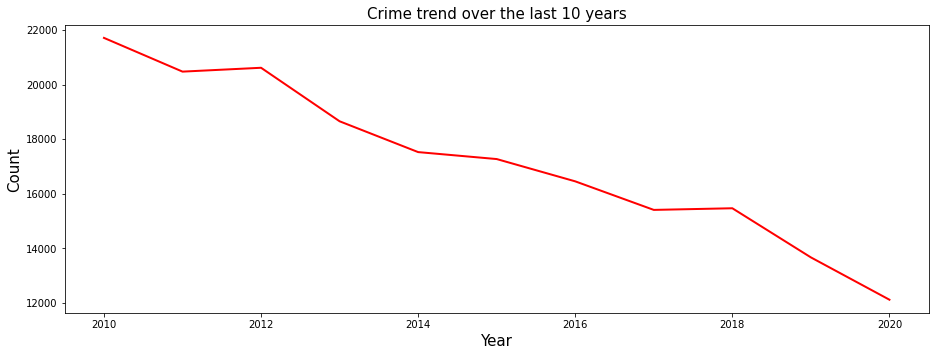

In [6]:
##plt.plot(Number_crimes_over_year['Year'],Number_crimes_over_year['frequency'],linewidth=2,color='red',)
fig = plt.figure()
axes = fig.add_axes([2, 1, 2, 1])
axes.plot(Number_crimes_over_year['Year'],Number_crimes_over_year['crime_count'],linewidth=2,color='red')
axes.set_xlabel('Year',fontsize=15)
axes.set_ylabel('Count',fontsize=15)
axes.set_title('Crime trend over the last 10 years',fontsize=15)

fig = plt.figure(figsize=(15, 5))
axes = fig.add_axes([2, 1, 2, 1])
plt.bar(Number_crimes_over_year['Year'],Number_crimes_over_year['crime_count'],width=.7,edgecolor="black")
axes.set_xlabel('Year',fontsize=20)
axes.set_ylabel('crime_count',fontsize=20)
plt.title('Crime over the last 10 years',fontsize=30)

#### The crime rate in buffalo city has drastically reduced from 2010 to  2020.This shows that there is scope to further reduce the crime rate in the future if we can identify the hot spots and take preventive measures to curb the crimes which occur mostly.

### 2. What kind of crimes occur most frequently?

In [7]:
Number_crimes = pd.read_sql_query("Select Incident_type.Parent_Incident, Count(Incident_type.Parent_Incident) as count from Incident INNER JOIN Incident_type on Incident.Incident_type_primary=Incident_type.Incident_type_primary  Group by Incident_type.Parent_Incident Order by Count(Incident_type.Parent_Incident) DESC;",conn)
Number_crimes.columns = ['Incident_type', 'values']

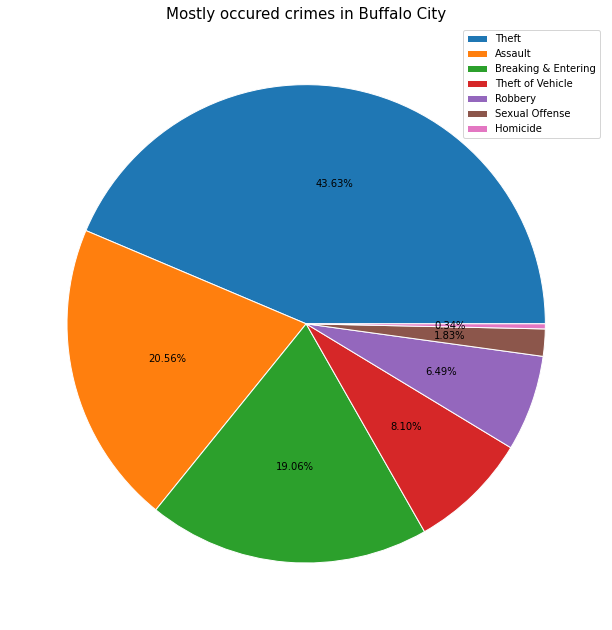

In [8]:
plt.figure(figsize=(15, 11))
plt.pie(Number_crimes['values'],autopct='%1.2f%%',wedgeprops={"linewidth": 1, "edgecolor": "white"})
plt.title('Mostly occured crimes in Buffalo City',fontsize=15)
plt.legend(labels = Number_crimes['Incident_type'],loc='upper right')

#### The most occurred crime in Buffalo city was theft  followed by assault

### 3. Which council Districts have the most number of crimes commited?

In [9]:
Council_District = pd.read_sql_query('''Select Council_District, Count(Council_District) as Count from Incident 
                                        Group by Council_District
                                        Order by Count(Council_District) DESC;''',conn)
Council_District.columns = ["Council District", "No of Crimes"]
display(Council_District[0:9])

,Council District,No of Crimes
0,ELLICOTT,44826
1,NORTH,36121
2,LOVEJOY,32574
3,UNIVERSITY,32224
4,FILLMORE,31047
5,MASTEN,30681
6,NIAGARA,30105
7,DELAWARE,18469
8,SOUTH,17202


Text(0.5, 1.0, 'Council District VS Number of crimes')

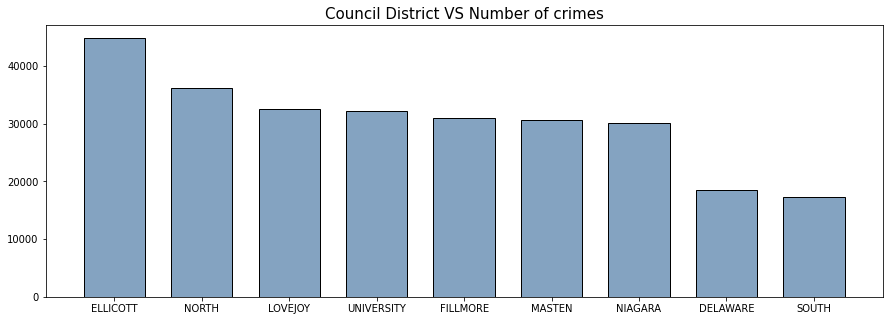

In [10]:
plt.figure(figsize=(15, 5))
plt.bar(Council_District['Council District'][0:9],Council_District['No of Crimes'][0:9], color=(0.2, 0.4, 0.6, 0.6),width=.7,edgecolor="black")
plt.title('Council District VS Number of crimes',fontsize=15)

#### The council district with most occurred crime was Ellicott followed by north.

### 4. Which Police Districts have the most number of crimes commited?

In [11]:
Police_District = pd.read_sql_query("Select Police_District, Count(Case_number) as Count from Incident Group by Police_District Order by Count(Case_number) DESC ;",conn)
Police_District.columns = ["Police District", "No of Crimes"]
display(Police_District[0:5])

,Police District,No of Crimes
0,District E,64339
1,District D,64299
2,District B,62581
3,District C,50301
4,District A,31865


Text(0.5, 1.0, 'Police District with more number of crimes')

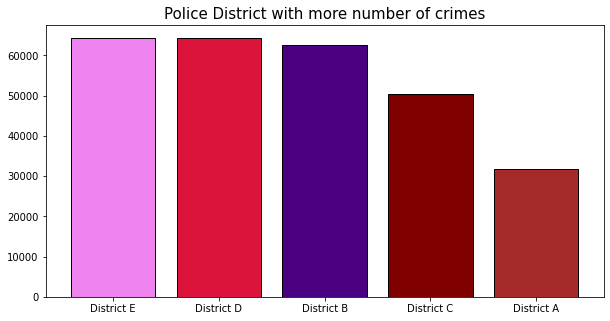

In [12]:

plt.figure(figsize=(10, 5))
plt.bar(Police_District['Police District'][0:5],Police_District['No of Crimes'][0:5],color=['violet', 'crimson', 'indigo', 'maroon','brown'],width=.8,edgecolor="black")
plt.title('Police District with more number of crimes',fontsize=15)

#### The police districts with the most crime rates were District E and District D.

### 5. Which  Neighbourhood in Buffalo city is mostly unsafe?

In [13]:
Neighbourhood = pd.read_sql_query("select * from (Select Neighbourhood, Count(Case_number) as Count from Incident  Group by Neighbourhood Order by Count(Case_number) DESC) where Count>10000 ;",conn)
Neighbourhood.columns = ["Neighbourhood", "No of Crimes"]
display(Neighbourhood)

,Neighbourhood,No of Crimes
0,Broadway Fillmore,15833
1,Central,14829
2,Kensington-Bailey,14442
3,North Park,13425
4,Genesee-Moselle,12575
5,Schiller Park,11768
6,Elmwood Bidwell,11584
7,Elmwood Bryant,11132
8,Upper West Side,10574
9,University Heights,10453


Text(0.5, 1.0, 'Neighbourhood with maximum crime')

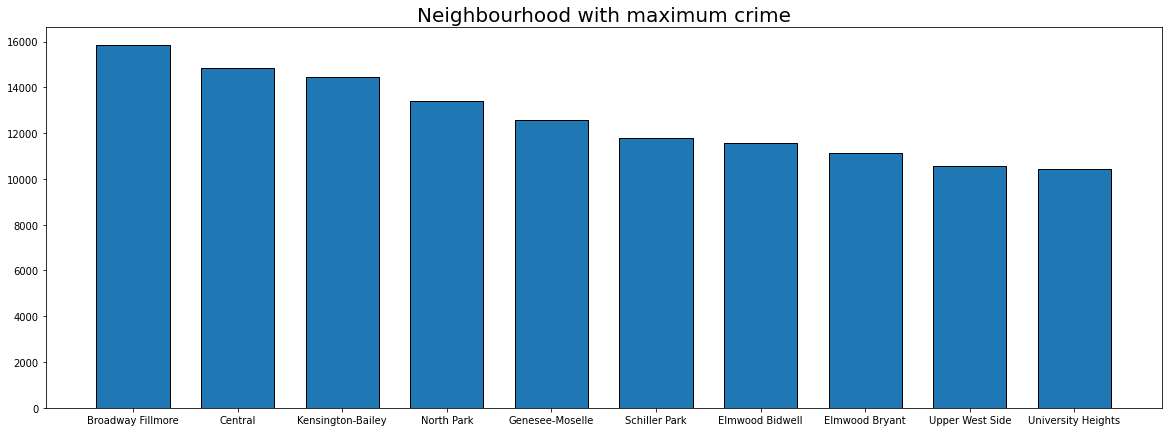

In [14]:
plt.figure(figsize=(20, 7))
plt.bar(Neighbourhood['Neighbourhood'],Neighbourhood['No of Crimes'],width=.7,edgecolor="black")
plt.title('Neighbourhood with maximum crime',fontsize=20)

#### Broadway Fillmore in buffalo city was found to be the most dangerous neighborhood in Buffalo.

### 6. What hour of the day the crime rate is high?

In [15]:
hour_of_day =pd.read_sql_query("Select hour_of_day, count(Case_number) as Count from Incident Group by hour_of_day;",conn)
hour_of_day.columns = ["Hour", "No of Crimes"]

Text(0.5, 1.0, 'Number of crimes each hour of the day')

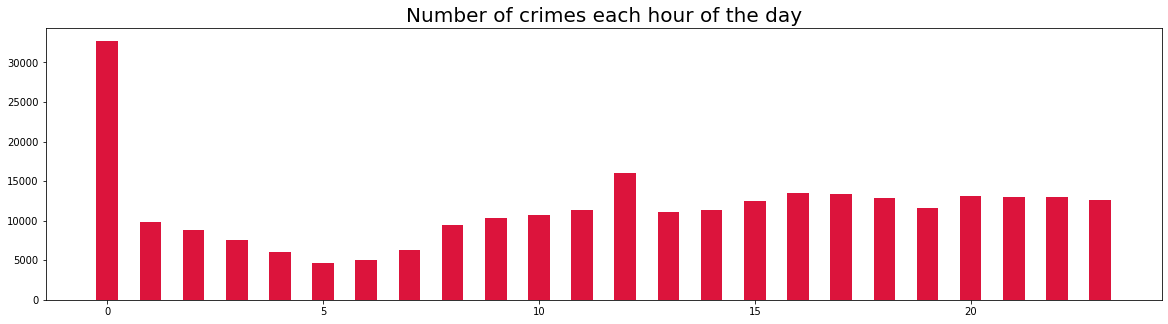

In [16]:
plt.figure(figsize=(20, 5))
plt.bar(hour_of_day['Hour'],hour_of_day['No of Crimes'],width=.5,color="crimson")
plt.title('Number of crimes each hour of the day',fontsize=20)

#### Most of the crimes occurred at midnight 12pm and there was a spike observed at 12 noon as well.


## Which days of the week crime rate is high?

In [17]:
weekly_crimes = pd.read_sql_query('''select * from (Select day_of_week,count(Case_number) as count from Incident INNER JOIN 
                                                   Incident_type on Incident.Incident_type_primary=Incident_type.Incident_type_primary  
                                                   Group by day_of_week
                                                   Order by Count(Case_number) DESC) where day_of_week is NOT NULL''',conn)
weekly_crimes.columns = ['Day','Count of crimes']
display(weekly_crimes[0:7])

,Day,Count of crimes
0,FRIDAY,41500
1,SATURDAY,41049
2,MONDAY,39232
3,WEDNESDAY,38936
4,SUNDAY,38644
5,TUESDAY,38636
6,THURSDAY,38626


Text(0.5, 1.0, 'Day of Week vs Crime Count')

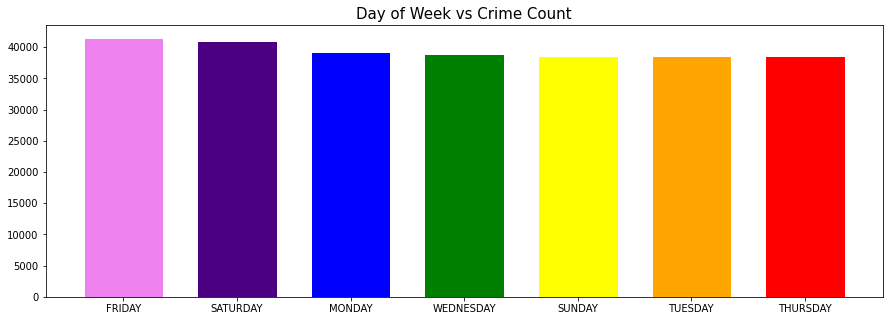

In [18]:
plt.figure(figsize=(15, 5))
plt.bar(weekly_crimes['Day'][0:7],weekly_crimes['Count of crimes'][0:7],color=['violet', 'indigo', 'blue','green','yellow','orange','red'],width=.7,edgecolor="white")
plt.title('Day of Week vs Crime Count',fontsize=15)

#### More crimes occurr on Fridays and Saturdays compared to other days of the week.

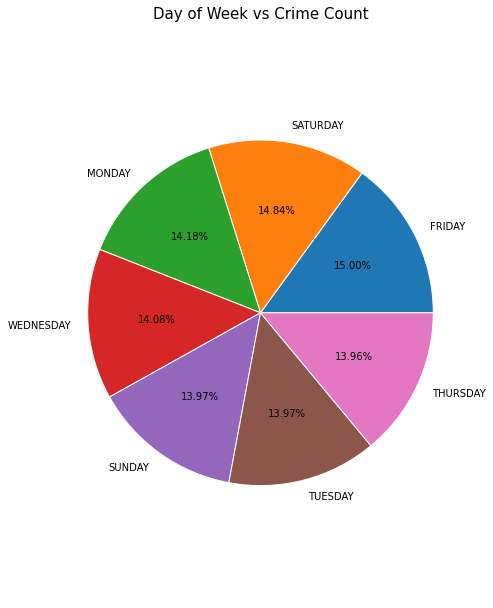

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,2])
ax.axis('equal')
ax.pie(weekly_crimes['Count of crimes'][0:7], labels = weekly_crimes['Day'][0:7],autopct='%1.2f%%',wedgeprops={"linewidth": 1, "edgecolor": "white"})
plt.title('Day of Week vs Crime Count',fontsize=15)
plt.show()



### Conclusion

#### The results of the above analyses can help the buffalo police, they can patrol more during the peak hours of crimes and during Fridays and Saturdays.
#### This data can also be further useful for people who are planning to buy a property in buffalo city they will be able to avoid the neighborhoods with more crime rates.This can help the people looking to rent or buy property. Additionally, it can also help the property owners to tag their property at reasonable price
